In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

districts_info = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")
products_info = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")

# Getting An Overview of the Dataset

 we are given multiple .csv files as shown in below figure. The main information contained in these files is **which tools are used with what engagement in which school district** in the United States of America in 2020.

The **districts_info.csv** file contains information about each school district and the **products_info.csv** file contains information about the top 370 tools used for digital learning. For each school district, there is an additional file that contains the engagement for each tool for everyday in 2020. The files can be joined by the key columns <font color='lightblue'>district_id</font> and <font color='orange'>lp_id</font>.

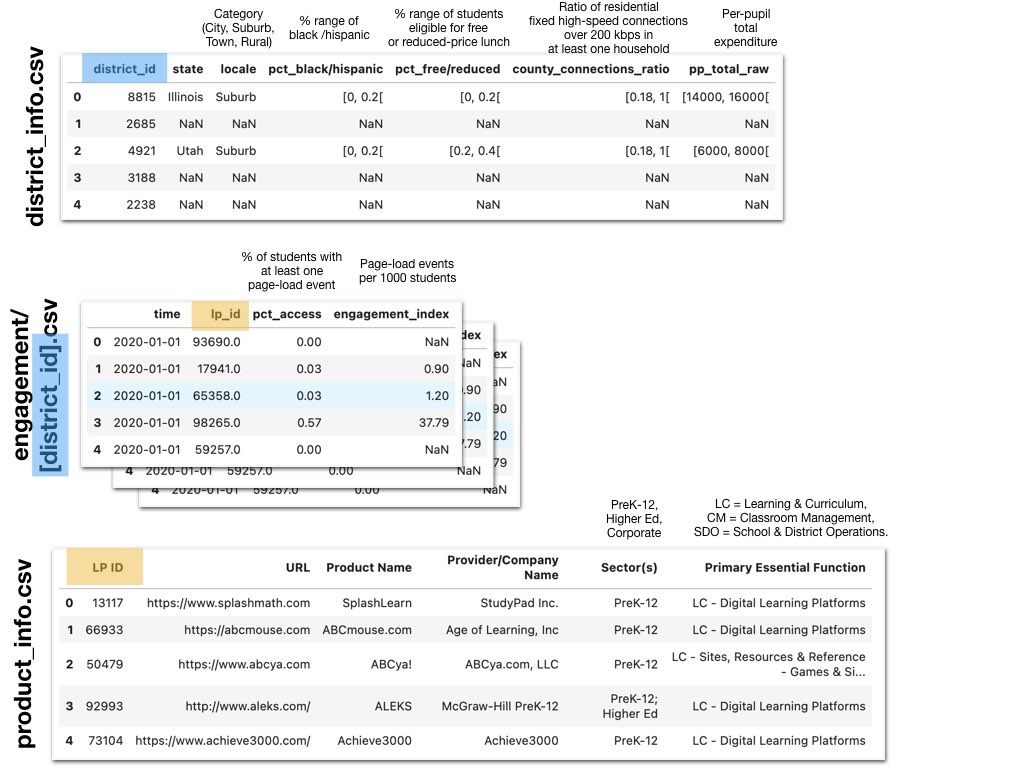

# Preprocessing


In the following subsections, I will proceed with the following basic preprocessing steps:
- <font color='salmon'>dropping 57 school districts with NaN states (57/233 ~ 25%)</font>
- <font color='turquoise'>one-hot encoding the product sectors</font>
- <font color='orange'>splitting up the primary essential function into main and sub category</font>
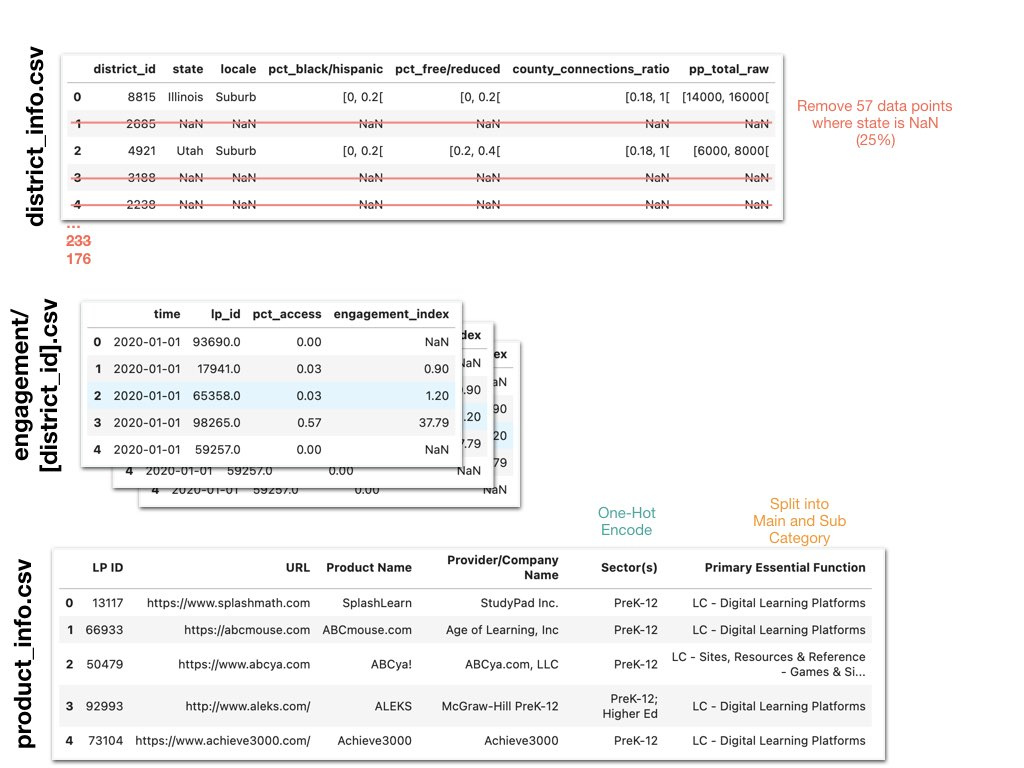

<font color='salmon'>Dropping Districts with NaN States</font>

In [ ]:
districts_info = districts_info[districts_info.state.notna()].reset_index(drop=True)

<font color='turquoise'>One-Hot Encoding the Product Sectors</font>

In [ ]:
temp_sectors = products_info['Sector(s)'].str.get_dummies(sep="; ")
temp_sectors.columns = [f"sector_{re.sub(' ', '', c)}" for c in temp_sectors.columns]
products_info = products_info.join(temp_sectors)
products_info.drop("Sector(s)", axis=1, inplace=True)

del temp_sectors

<font color='orange'>Splitting up the Primary Essential Function</font>

In [ ]:
products_info['primary_function_main'] = products_info['Primary Essential Function'].apply(lambda x: x.split(' - ')[0] if x == x else x)
products_info['primary_function_sub'] = products_info['Primary Essential Function'].apply(lambda x: x.split(' - ')[1] if x == x else x)

# Synchronize similar values
products_info['primary_function_sub'] = products_info['primary_function_sub'].replace({'Sites, Resources & References' : 'Sites, Resources & Reference'})
products_info.drop("Primary Essential Function", axis=1, inplace=True)

After preprocessing, we are left with a reduced `districts_info` dataframe with 176 districts and the `product_info` dataframe looks are follows:

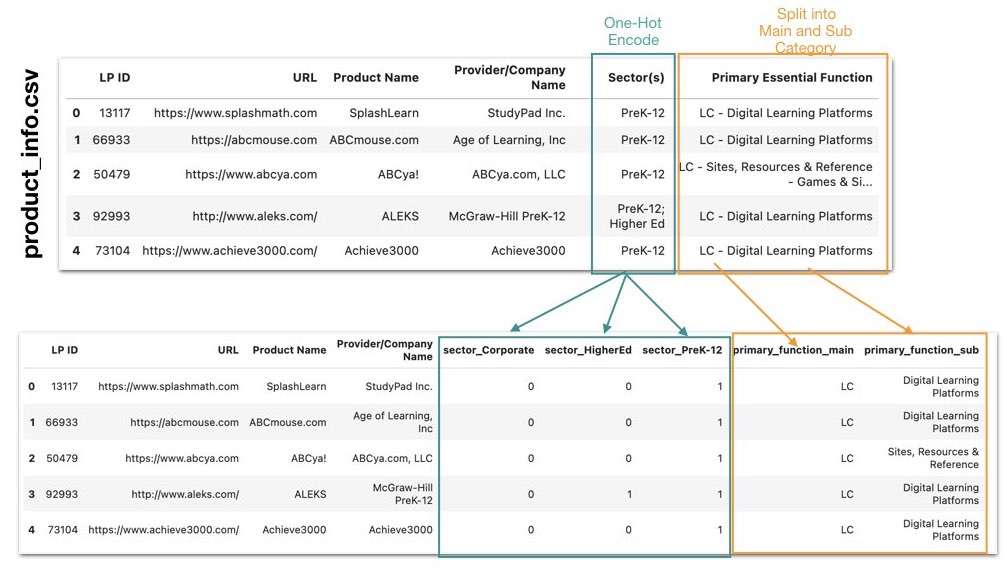

Furthermore, we will concatenate the engagement data from all remaining districts in one dataframe by adding the key column `district_id` to each engagement file as shown below.
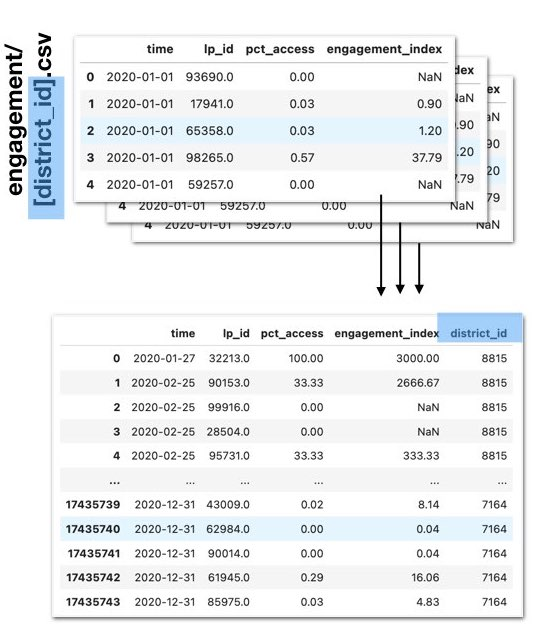

In [ ]:
PATH = '../input/learnplatform-covid19-impact-on-digital-learning/engagement_data' 

temp = []

for district in districts_info.district_id.unique():
    df = pd.read_csv(f'{PATH}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    temp.append(df)
    
    
engagement = pd.concat(temp)
engagement = engagement.reset_index(drop=True)

For the majority of school districts (133) there are 366 unique days available. However, for 43 school districts there are less than 366 unique days of data available. For example for district 3670 there is only data available from 2020-02-15 to 2020-03-02 or for district 2872 there is only data available for January 2020 and then two more single days in Feburary and March.

In [ ]:
engagement.head()

In [ ]:
engagement.groupby('district_id').time.nunique()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.histplot(engagement.groupby('district_id').time.nunique(), bins=30)
ax.set_title('Unique Days of Engagement Data per District')
plt.show()

To make the data easier to compare, we will only consider distrcits with engagement data for everyday in 2020.

In [ ]:
# Delete previously created engagement dataframe and create a new one
del engagement

temp = []

for district in districts_info.district_id.unique():
    df = pd.read_csv(f'{PATH}/{district}.csv', index_col=None, header=0)
    df["district_id"] = district
    if df.time.nunique() == 366:
        temp.append(df)

engagement = pd.concat(temp)
engagement = engagement.reset_index(drop=True)

# Only consider districts with full 2020 engagement data
districts_info = districts_info[districts_info.district_id.isin(engagement.district_id.unique())].reset_index(drop=True)
products_info = products_info[products_info['LP ID'].isin(engagement.lp_id.unique())].reset_index(drop=True)

Furthermore, if we look at a few sample districts, we can quickly see that most districts use more than the 369 unique products from `products_info`. In fact, the concatenated engagement data contains more than 8000 unique products. Since we don't have any additional information the majority of these products, we will remove engagement data for unknown products. This reduces the engagement data roughly by half.

In [ ]:
for district in districts_info.district_id.unique()[:10]:
    df = pd.read_csv(f'{PATH}/{district}.csv', index_col=None, header=0)
    print(f'District {district} uses {df.lp_id.nunique()} unique products.')
    
print(f'\nConcatenated engagement data contains {engagement.lp_id.nunique()} unique products.')


In [ ]:
print(len(engagement))
engagement = engagement[engagement.lp_id.isin(products_info['LP ID'].unique())]
print(len(engagement))

Note that at this stage, we have **removed quite a bit of data**. This obviously can lead to loss of information. However, on the other hand this makes the data easier to compare and therefore, it can help us in finding insights more quickly. 
To summarize, we have **removed districts** without any information on the location 
and we have **removed districts** with incomplete data in 2020.

Finally, we will convert the `time` column to the type `datetime64[ns]` for easier handling.

In [ ]:
engagement.time = engagement.time.astype('datetime64[ns]')

# Initial Exploratory Data Analysis (EDA)

Let's begin with a simple EDA. First of all, I am interested **how diverse the available school districts are**. As you can see in below plot, the available data does not cover all the states in the U.S. (19/50). The states with the most available school districts are CT (29) and UT (24) while there are also states with only one school district (FL, TN, NY, AZ).

In [ ]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

districts_info['state_abbrev'] = districts_info['state'].replace(us_state_abbrev)
districts_info_by_state = districts_info['state_abbrev'].value_counts().to_frame().reset_index(drop=False)
districts_info_by_state.columns = ['state_abbrev', 'num_districts']

fig = go.Figure()
layout = dict(
    title_text = "Number of Available School Districts per State",
    geo_scope='usa',
)

fig.add_trace(
    go.Choropleth(
        locations=districts_info_by_state.state_abbrev,
        zmax=1,
        z = districts_info_by_state.num_districts,
        locationmode = 'USA-states', # set of locations match entries in `locations`
        marker_line_color='white',
        geo='geo',
        colorscale=px.colors.sequential.Teal, 
    )
)
            
fig.update_layout(layout)   
fig.show()

In [ ]:
 districts_info['state_abbrev'].value_counts().to_frame()

In [ ]:
districts_info.pp_total_raw.unique()
temp = districts_info.groupby('locale').pp_total_raw.value_counts().to_frame()
temp.columns = ['amount']

temp = temp.reset_index(drop=False)

temp = temp.pivot(index='locale', columns='pp_total_raw')['amount']
temp = temp[['[4000, 6000[', '[6000, 8000[', '[8000, 10000[', '[10000, 12000[',
       '[12000, 14000[', '[14000, 16000[', '[16000, 18000[', 
       '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', ]]


fig, ax = plt.subplots(1, 2, figsize=(24,4))

sns.countplot(data=districts_info, x='locale', ax=ax[0], palette='GnBu')

sns.heatmap(temp, annot=True,  cmap='GnBu', ax=ax[1])
ax[1].set_title('Heatmap of Districts According To locale and pp_total_raw')
plt.show()

If we look at the **distributions of the remaining columns** in `districts_info`, you can quickly see that `county_connections_ratio` only has one unique value which is `[0.18, 1[`.  So, this column does not really contain any valuable information.

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16,8))

sns.countplot(data=districts_info, x='pct_black/hispanic', order=['[0, 0.2[', '[0.2, 0.4[', '[0.4, 0.6[', '[0.6, 0.8[','[0.8, 1[', ], palette='GnBu', ax=ax[0,0])
ax[0,0].set_ylim([0,135])
sns.countplot(data=districts_info, x='pct_free/reduced', order=['[0, 0.2[', '[0.2, 0.4[', '[0.4, 0.6[', '[0.6, 0.8[','[0.8, 1[', ], palette='GnBu', ax=ax[0,1])
ax[0,1].set_ylim([0,135])

sns.countplot(data=districts_info, x='county_connections_ratio', palette='GnBu', ax=ax[1,0])
ax[1,0].set_ylim([0,135])
sns.countplot(data=districts_info, x='pp_total_raw', order=['[4000, 6000[', '[6000, 8000[', '[8000, 10000[', '[10000, 12000[',
       '[12000, 14000[', '[14000, 16000[', '[16000, 18000[', 
       '[18000, 20000[', '[20000, 22000[', '[22000, 24000[', ], palette='GnBu', ax=ax[1,1])
ax[1,1].set_ylim([0,135])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
def replace_ranges_pct(range_str):
    if range_str == '[0, 0.2[':
        return 0.1
    elif range_str == '[0.2, 0.4[':
        return 0.3
    elif range_str == '[0.4, 0.6[':
        return 0.5
    elif range_str == '[0.6, 0.8[':
        return 0.7
    elif range_str == '[0.8, 1[':
        return 0.9
    else:
        return np.nan
    
def replace_ranges_raw(range_str):
    if range_str == '[4000, 6000[':
        return 5000
    elif range_str == '[6000, 8000[':
        return 7000
    elif range_str == '[8000, 10000[':
        return 9000
    elif range_str == '[10000, 12000[':
        return 11000
    elif range_str ==  '[12000, 14000[':
        return 13000
    elif range_str ==  '[14000, 16000[':
        return 15000
    elif range_str == '[16000, 18000[':
        return 17000
    elif range_str ==  '[18000, 20000[':
        return 19000
    elif range_str ==  '[20000, 22000[':
        return 21000
    elif range_str ==  '[22000, 24000[':
        return 21000
    else: 
        return np.nan
    
districts_info['pct_black_hispanic_num'] = districts_info['pct_black/hispanic'].apply(lambda x: replace_ranges_pct(x))
districts_info['pct_free_reduced_num'] = districts_info['pct_free/reduced'].apply(lambda x: replace_ranges_pct(x))
districts_info['pp_total_raw_num'] = districts_info['pp_total_raw'].apply(lambda x: replace_ranges_raw(x))

def plot_state_mean_for_var(col):
    temp = districts_info.groupby('state_abbrev')[col].mean().to_frame().reset_index(drop=False)

    fig = go.Figure()
    layout = dict(
        title_text = f"Mean {col} per State",
        geo_scope='usa',
    )

    fig.add_trace(
        go.Choropleth(
            locations=temp.state_abbrev,
            zmax=1,
            z = temp[col],
            locationmode = 'USA-states', # set of locations match entries in `locations`
            marker_line_color='white',
            geo='geo',
            colorscale=px.colors.sequential.Teal, 
        )
    )

    fig.update_layout(layout)   
    fig.show()

plot_state_mean_for_var('pct_black_hispanic_num')
plot_state_mean_for_var('pct_free_reduced_num')
plot_state_mean_for_var('pp_total_raw_num')

The most common category in the column Primary Essential Function is Learning & Curriculum (LC) as shown on the below left figure. For the categories Classroom Management (CM) and School & District Operations (SDO) there are far fewer tool options available. 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.countplot(data=products_info, x='primary_function_main', palette ='GnBu', ax=ax[0])
ax[0].set_title('Main Categories in Primary Functions')

sns.countplot(data=products_info[products_info.primary_function_main == 'LC'], x='primary_function_sub', palette ='GnBu', ax=ax[1])
ax[1].set_title('Sub-Categories in Primary Function LC')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()

Now we will try to understand that meaning behind `pct_access` and `engagement_index`.

* `pct_access`: **% of students in the district have at least one page-load event** of a given product and on a given day
* `engagement_index`: **Total page-load events per 1000 students** of a given product and on a given day

In the first figure below, you can see the overall mean `pct_access` of all products of the category 'Virtual Classroom'. For better understanding, weekends are removed from this visualization as students will not attend classes on weekends and this would add a disturbing visual effect and make the plot more difficult to understand. Let's summarize what we see:
* the home schooling phase starts at the beginning of March
* there is a bell-shape between March and July
* during July and August there are summer holidays and therefore no classes to attend
* after the summer holidays the `pct_access` increases to a higher level as observed at the beginning of the pandemic and it stays somewhat constant
* there are a few drops in `pct_access` visible throughout the year - these might be national holidays or other holidays
* Zoom and Meet seem to be the two most popular products for virtual classrooms

Over the last quarter of 2020, we can see a `pct_access` of roughly 15. What does this mean? 15 % of students in the district have at least one page-load event of Zoom or Meet. To be honest, that seems a little bit low from the home schooling point of view given that every student needs to attend classes on a school day. However, this seems to hint at the fact that not all students had to attend classes virtually but were able to physically go to school. Judging from [this State-by-State Map of Where School Buildings Are Opened or Closed](https://www.edweek.org/leadership/map-where-are-schools-closed/2020/07) it seems like a lot of schools offered in-person education in 2020. **That means, when looking at digital learning, we should probably focus our analysis on districts where digital learning was actually applied to get some key insights**.

While for `pct_access` Zoom and Meet seem to have roughly similiar values, we can see in the lower graph that Meet has more than 4 times the value of Zoom for `engagement_index` in the last quarter of 2020. What does this mean? If we have 1000 page-load events per 1000 students for Zoom on a given day that means that one student uses Zoom once a day. In contrast, Meet is used 4 or 5 times daily on average per student.

To make things a little bit clearer: If every students has two applications on their phone, the `pct_access` indicates **how many of the students** access this app on a daily basis but the `engagement_index` tells you **how much the students engage** with that application on a daily basis.

In [ ]:
virtual_classroom_lp_id = products_info[products_info.primary_function_sub == 'Virtual Classroom']['LP ID'].unique()

# Remove weekends from the dataframe
engagement['weekday'] = pd.DatetimeIndex(engagement['time']).weekday
engagement_without_weekends = engagement[engagement.weekday < 5]

# Figure 1
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for virtual_classroom_product in virtual_classroom_lp_id:
    temp = engagement_without_weekends[engagement_without_weekends.lp_id == virtual_classroom_product].groupby('time').pct_access.mean().to_frame().reset_index(drop=False)
    sns.lineplot(x=temp.time, y=temp.pct_access, label=products_info[products_info['LP ID'] == virtual_classroom_product]['Product Name'].values[0])
plt.legend()
plt.show()

# Figure 2
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))
for virtual_classroom_product in virtual_classroom_lp_id:
    temp = engagement_without_weekends[engagement_without_weekends.lp_id == virtual_classroom_product].groupby('time').engagement_index.mean().to_frame().reset_index(drop=False)
    sns.lineplot(x=temp.time, y=temp.engagement_index, label=products_info[products_info['LP ID'] == virtual_classroom_product]['Product Name'].values[0])
plt.legend()
plt.show()

Below we can see the top 5 most accessed products for each LC sub-category sorted by the mean `pct_access` for 2020 over all districts. We can see that most of the products are on average accessed by less than 5 % of students on a daily basis. Exceptions are YouTube, Google Docs, and Canvas. YouTube in this case is a difficult one to evaluate since it can be used for leisure in addition to education, so we need to be careful here. Google Docs seems to make a lot of sense since students can use Google Docs. According to [Canvas](https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Canvas/ta-p/45) it is 
> Canvas is a web-based learning management system, or LMS. It is used by learning institutions, educators, and students to access and manage online course learning materials and communicate about skill development and learning achievement.

so it also makes sense that this one is quite often accessed.

Regarding the sub-category 'Career Planning & Job Search' the average `pct_access` is very low. This is probably due top the fact that career planning is only relevant to older students. Therefore, we can probably exclude this subcategory when inspecting the digital learning aspect.

In [ ]:
products_info['lp_id'] = products_info['LP ID'].copy()

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 8))

i = 0
j = 0
for subfunction in products_info[products_info.primary_function_main == 'LC'].primary_function_sub.unique():
    lp_ids = products_info[products_info.primary_function_sub == subfunction]['LP ID'].unique()

    temp = engagement_without_weekends[engagement_without_weekends.lp_id.isin(lp_ids)]
    temp = temp.groupby('lp_id').pct_access.mean().sort_values(ascending=False).to_frame().reset_index(drop=False)
    temp = temp.merge(products_info[['lp_id', 'Product Name']], on='lp_id').head()
    
    sns.barplot(data=temp, x='pct_access', y='Product Name', palette='GnBu', ax=ax[i, j])
    
    ax[i, j].set_title(f'Top 5 in \n{subfunction}', fontsize=12)
    ax[i, j].set_xlim([0, 20])
    j = j + 1
    if j == 3:
        i = i + 1
        j = 0
        
f.delaxes(ax[2, 1])
f.delaxes(ax[2, 2])

plt.tight_layout()
plt.show()


Just on a side note because I saw this on accident: **'Among Us'**, which is a multiplayer game that was quite popular during 2020, **is also listed as a product under the main category LC**. So, we need to take the list of products with a grain of salt when we are evaluating them as 'digital learning products'. 

In [ ]:
products_info[products_info['Product Name'] == 'Among Us']

In above example to showcase the difference between `pct_access` and `engagement_index`, we intuitively chose products from the subfunction 'Virtual Classroom' based on our "domain knowledge" that in-person education does not need video conferencing tools but during the pandemic these tools gained a lot of popularity. Let's do a quick analysis and see whether the avaiable data reflects the assumption we had made before.

For this purpose, we will **average the `pct_access` and `engagement_index` data over each quarter in 2020 and then take the difference between the last quarter of 2020 and the first quarter of 2020.** Based on this approach, we should be able to see which subfunction category that gained the most engagement over the course of the pandemic in 2020.

As you can see in the below left figure, the data reflects our assumption that products of the subfunction 'Virtual Classroom' gained the most change in `pct_access`. At second place, we have Learning Management Systems (LMS). These top two categories are also the top two categories from the `engagement_index` point of view.

In [ ]:
engagement['quarter'] = pd.DatetimeIndex(engagement['time']).quarter.astype(str)

temp = engagement.merge(products_info[['lp_id', 'Product Name', 'primary_function_main', 'primary_function_sub']], on='lp_id')
temp = temp[temp.primary_function_sub.notna()]
temp = temp.groupby(['quarter', 'primary_function_sub'])['pct_access', 'engagement_index'].mean().reset_index(drop=False)

temp = temp.pivot(index='primary_function_sub', columns='quarter')[['pct_access', 'engagement_index']].fillna(0)

temp.columns = ["_".join(a) for a in temp.columns.to_flat_index()]

temp['pct_access_delta'] = temp['pct_access_4'] - temp['pct_access_1']
temp['engagement_index_delta'] = temp['engagement_index_4'] - temp['engagement_index_1']
temp=temp.reset_index(drop=False)
#temp = temp.merge(products_info[['lp_id', 'Product Name', 'primary_function_sub']], on='lp_id')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

df = temp.sort_values(by='pct_access_delta', ascending=False)#.head(5)

sns.barplot(data=df, x='pct_access_delta', y='primary_function_sub', palette='GnBu', ax=ax[0])

df = temp.sort_values(by='engagement_index_delta', ascending=False)#.head(5)

sns.barplot(data=df, x='engagement_index_delta', y='primary_function_sub', palette='GnBu', ax=ax[1])
plt.tight_layout()
plt.show()

The same approach as above is used below for the product level instead of the subfunction level. 

In [ ]:

temp = engagement.fillna(0).groupby(['quarter', 'lp_id'])['pct_access', 'engagement_index'].mean().reset_index(drop=False)

temp = temp.pivot(index='lp_id', columns='quarter')[['pct_access', 'engagement_index']].fillna(0)

temp.columns = ["_".join(a) for a in temp.columns.to_flat_index()]

temp['pct_access_delta'] = temp['pct_access_4'] - temp['pct_access_1']
temp['engagement_index_delta'] = temp['engagement_index_4'] - temp['engagement_index_1']
temp = temp.merge(products_info[['lp_id', 'Product Name', 'primary_function_sub']], on='lp_id')

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

df = temp.sort_values(by='pct_access_delta', ascending=False).head(10)

sns.barplot(data=df, x='pct_access_delta', y='Product Name', palette='GnBu', ax=ax[0])

df = temp.sort_values(by='engagement_index_delta', ascending=False).head(10)

sns.barplot(data=df, x='engagement_index_delta', y='Product Name', palette='GnBu', ax=ax[1])
plt.tight_layout()
plt.show()

**Summary**
* Depending on what you want to achieve you might want to carefully preselect districts. Note that we approach in this notebook might not necessarily suit your individual purposes.
* When looking at digital learning, you might want to spend sometime in figuring out which districts actually applied digital learning